In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\df_merged.csv")

### Remove other 2 predictors when training.

In [3]:
df.head()

,solvent_ID,smiles,Binding_Energy_eV,solubility_CO2 [mol/L],viscosity [Pa s],nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,lumo_eV,homo_lumo_gap_eV,polarizability_ang3,min_partial_charge,max_partial_charge,min_abs_partial_charge,max_abs_partial_charge,vib_freq_min_cm1,vib_freq_max_cm1,vib_freq_count
0,zinc_5593217,COCCNC(=O)[C@@H](CC)C,-0.246414,0.097848,0.011764,0.0,0.0,12.906117,2.122425,4.244850,...,-6.330932,181.930993,748.130500,-0.832151,0.392923,0.034817,0.832151,23.0414,3627.7857,78.0
1,zinc_400210175,CO[C@H](C1CC1)CN1CCCCC1,-0.239933,0.117575,0.007448,0.0,1.0,17.343700,2.348592,4.557405,...,1.910386,161.701629,933.997796,-1.140739,0.562172,0.001836,1.140739,28.8558,3225.7980,96.0
2,zinc_5696920,NOCCN(C)C,-0.219656,0.097619,0.002281,0.0,1.0,7.727407,1.931852,3.863703,...,4.894440,168.343554,496.654099,-0.802413,0.379028,0.149089,0.802413,52.1440,3517.7383,51.0
3,zinc_685002938,C[C@@H](CN(CC1CC1)CC(F)F)O,-0.325154,0.088216,0.025603,0.0,1.0,14.943352,2.294945,4.451333,...,-1.984432,171.357226,807.127445,-0.794729,0.647513,0.076133,0.794729,26.9357,3729.3970,84.0
4,zinc_52602135,CNC[C@@H](C(C)C)OC,-0.288984,0.131763,0.001110,0.0,1.0,10.199109,2.119166,4.238332,...,2.317639,167.803019,655.958528,-0.847175,0.397601,0.172656,0.847175,62.5690,3522.0361,72.0


In [4]:
meta_cols = ['solvent_ID', 'smiles']
# target = 'Binding_Energy_eV'  # or 'solubility_CO2 [mol/L]', 'viscosity [Pa s]'
target = 'viscosity [Pa s]'  # or 'solubility_CO2 [mol/L]', 'viscosity [Pa s]'
X = df.drop(columns=meta_cols + [target, 'solubility_CO2 [mol/L]', 'Binding_Energy_eV'])
y = df[target]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='viscosity [Pa s]', ylabel='Count'>

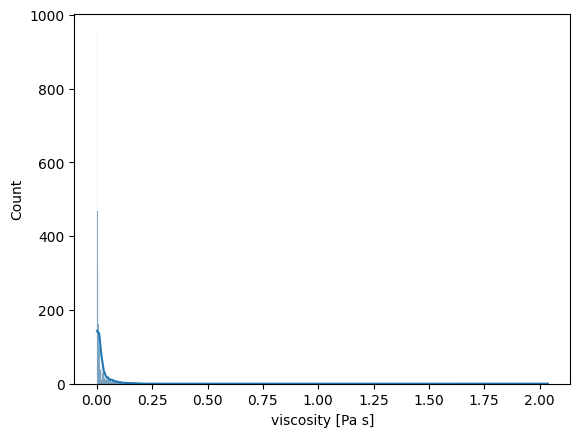

In [6]:
sns.histplot(y, kde=True)

In [7]:
# y_log = np.log1p(y)  # log1p is safer if there are very small values (~0)
# sns.histplot(y_log, kde=True)

In [8]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')  # works with negatives too
y_trans = pt.fit_transform(y.values.reshape(-1, 1)).flatten()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

<Axes: ylabel='Count'>

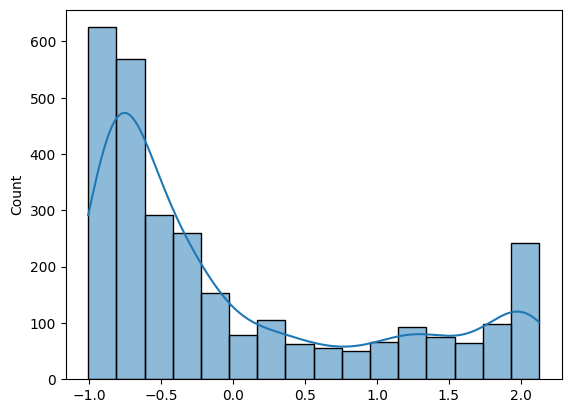

In [10]:
sns.histplot(y_trans, kde=True)

In [11]:
# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer(output_distribution='normal')
# y_train_trans = qt.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
# sns.histplot(y_log, kde=True)

In [15]:
# # XGB model with GPU support
# xgb = XGBRegressor(
#     tree_method='gpu_hist',  # key line for GPU
#     device='cuda', 
#     random_state=42
# )

In [16]:
# # Define hyperparameter space
# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_lambda': [0.1, 1, 10]
# }

In [17]:
# # RandomizedSearchCV with GPU-based XGBoost
# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=30,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=2,
#     n_jobs=1  # must be 1 when using GPU with XGBoost
# )

In [18]:
xgb = XGBRegressor(
    tree_method='gpu_hist',
    device='cuda',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    learning_rate=0.01,
    n_estimators=500,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:44:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# # Train the model
# random_search.fit(X_train_scaled, y_train_trans)

# # Evaluate best model
# best_model = random_search.best_estimator_

In [20]:
# y_pred_trans = xgb.predict(X_test_scaled)
# clip_max = 20  # exp(20) ≈ 4.85 million — already very high

# y_pred_log_clipped = np.clip(y_pred_trans, a_min=None, a_max=clip_max)
# y_test_log_clipped = np.clip(y_test, a_min=None, a_max=clip_max)

# y_pred = np.expm1(y_pred_log_clipped)
# y_test = np.expm1(y_test_log_clipped)
# # y_pred = qt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print("Fixed RMSE:", round(rmse, 4))
# print("Fixed R²:", round(r2, 4))

# # -------------------------------------
# # 6. Actual vs Predicted Plot
# # -------------------------------------
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
# plt.xlabel("Actual viscosity [Pa s]")
# plt.ylabel("Predicted viscosity [Pa s]")
# plt.title("Actual vs Predicted viscosity [Pa s] (XGBoost with Yeo-Johnson)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Fixed RMSE: 0.9719
Fixed R²: 0.0339


c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:2676: UserWarning: [21:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


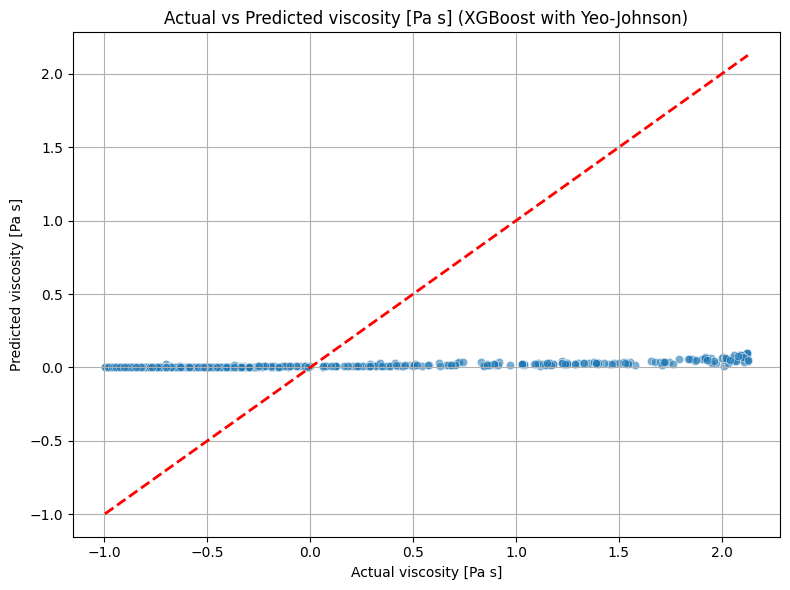

In [21]:
y_pred_trans = xgb.predict(X_test_scaled)
y_pred = pt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
# y_pred = qt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Fixed RMSE:", round(rmse, 4))
print("Fixed R²:", round(r2, 4))

# -------------------------------------
# 6. Actual vs Predicted Plot
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual viscosity [Pa s]")
plt.ylabel("Predicted viscosity [Pa s]")
plt.title("Actual vs Predicted viscosity [Pa s] (XGBoost with Yeo-Johnson)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# best_model.get_params

In [23]:
# # y_pred = best_model.predict(X_test_scaled)
# y_pred_trans = best_model.predict(X_test_scaled)
# y_pred = pt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print("Best XGBoost Params:", random_search.best_params_)
# print(f"XGBoost RMSE: {rmse:.4f}")
# print(f"XGBoost R² Score: {r2:.4f}")

In [24]:
feature_names = X.columns.tolist()  # This should match the model's input

In [25]:
# Use scaled test set for SHAP input
import shap
explainer = shap.Explainer(xgb, feature_names=feature_names)
shap_values = explainer(X_test_scaled)

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


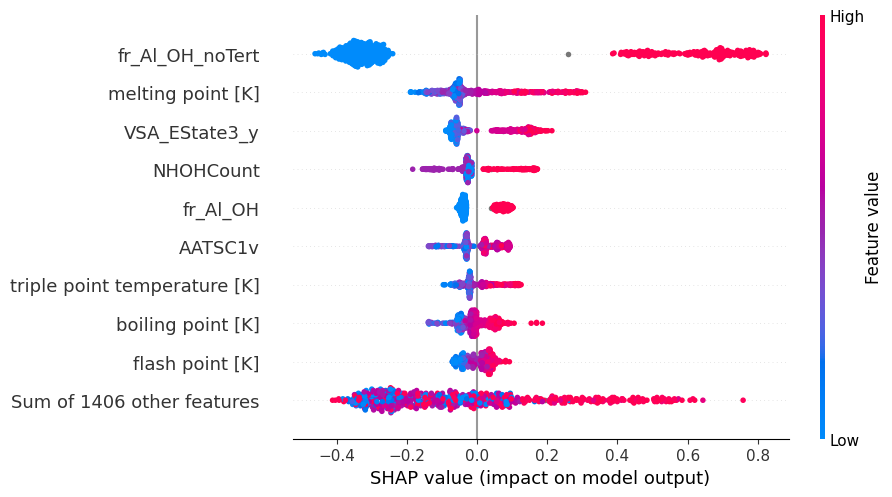

In [26]:
# Visualize top feature contributions across all samples
shap.plots.beeswarm(shap_values, max_display=10)


### Use actual descriptor names

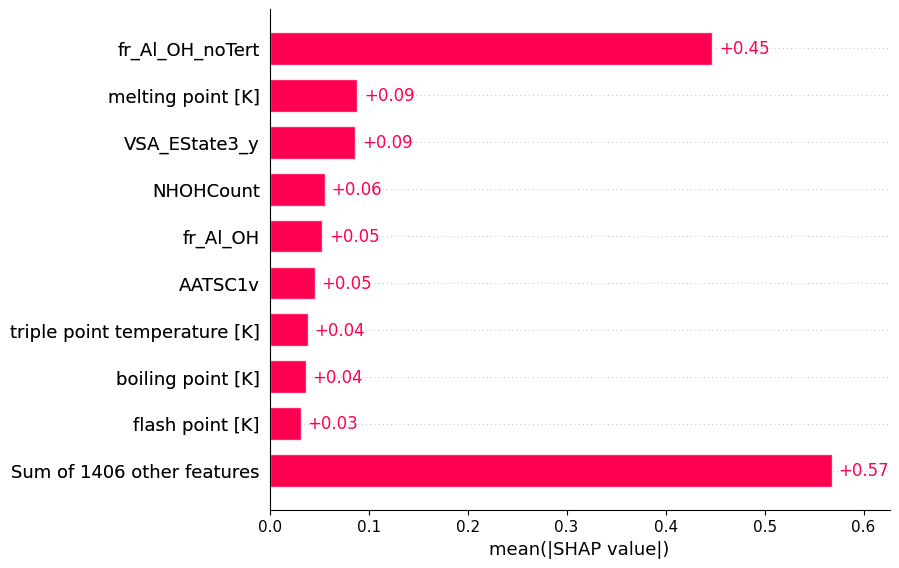

In [27]:
shap.plots.bar(shap_values, max_display=10)

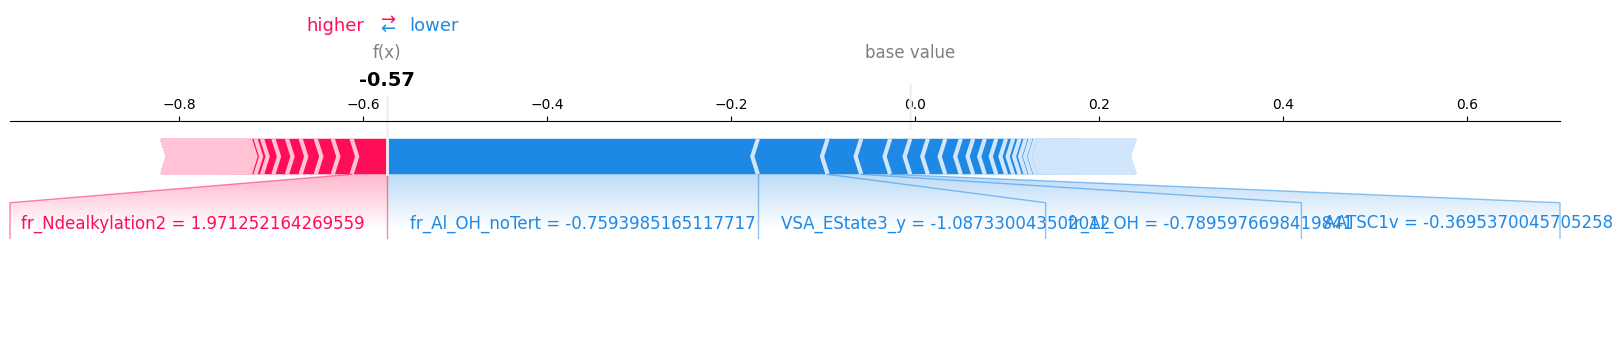

In [28]:
# Get index of a specific test point
i = 0  # change to view other points
shap.plots.force(shap_values[i], matplotlib=True)


### Predicted vs Actual values (include R2 score and rmse)
### Include a histogram of residuals

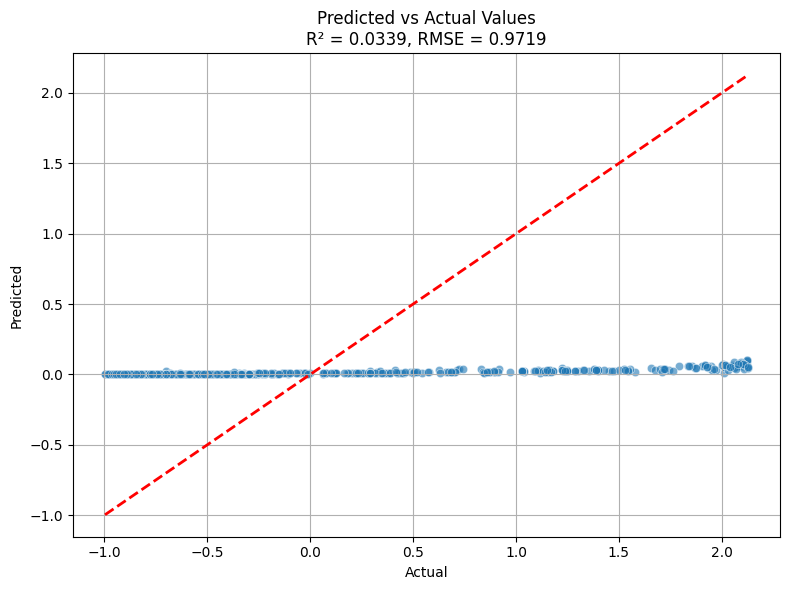

In [29]:
residuals = y_test - y_pred

# --- A. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.title(f"Predicted vs Actual Values\nR² = {r2:.4f}, RMSE = {rmse:.4f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

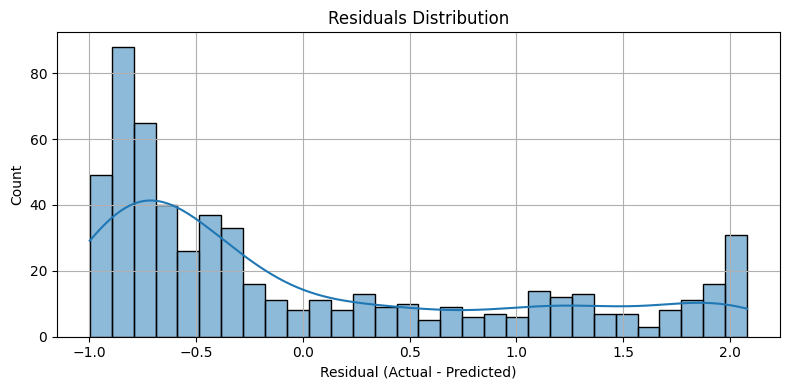

In [30]:
# --- B. Histogram of Residuals ---
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()